In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import pickle

2024-10-15 11:28:25.016368: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-15 11:28:25.397659: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 11:28:25.397707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 11:28:25.447856: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 11:28:25.552638: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices())

2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-10-15 11:28:28.373700: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-15 11:28:28.545830: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-15 11:28:28.545875: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])  # Set your memory limit here
    except RuntimeError as e:
        print(e)

In [4]:
def inverse_convert_time_window(data_3d):
    samples, timesteps, variables = data_3d.shape
    data_2d = np.zeros((samples + timesteps - 1, variables))

    count = np.zeros((samples + timesteps - 1, variables))

    for i in range(samples):
        data_2d[i:i+timesteps] += data_3d[i]
        count[i:i+timesteps] += 1

    # Average the overlapping segments
    data_2d /= count
    return data_2d

In [5]:
def convert_time_window(data, timesteps):
    samples = data.shape[0] - timesteps + 1  # Number of samples in the new 3D array
    variables = data.shape[1]  # Number of variables (features)

    data_3d = np.zeros((samples, timesteps, variables))

    for i in range(samples):
        data_3d[i] = data[i:i+timesteps]
    return data_3d

In [6]:
def calculate_reconstruction_loss(data, reconstructions):
    reconstruction_errors = np.mean(np.abs(data - reconstructions), axis=1)
    total_r_e = np.sum(reconstruction_errors)
    relative_reconstruction_errors = np.array([(r_e / total_r_e) * 100 for r_e in reconstruction_errors])
    return reconstruction_errors

In [7]:
def find_optimal_threshold(reconstruction_errors, y_true):
    from sklearn.metrics import accuracy_score, balanced_accuracy_score

    best_threshold = 0.0
    best_f1 = 0.0
    best_y_pred = np.zeros(reconstruction_errors.shape)
    # q3 = np.percentile(reconstruction_errors, 75)
    # q1 = np.percentile(reconstruction_errors, 25)
    # iqr = q3 - q1
    upper_bound = np.max(reconstruction_errors)
    lower_bound = np.min(reconstruction_errors)

    thresholds = np.linspace(lower_bound, upper_bound, num=1000)

    for threshold in thresholds:
        y_pred = np.where((reconstruction_errors > threshold) ,1, 0)
        # print(y_pred.shape)
        # print(y_true.shape)

        # Hitung F1-Score
        current_f1 = balanced_accuracy_score(y_true.astype(bool), y_pred.astype(bool))

        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
            best_y_pred = y_pred

    return best_threshold, best_f1, best_y_pred

# def find_optimal_threshold(reconstruction_errors, y_true):
#     from sklearn.metrics import f1_score, accuracy_score
    
#     best_threshold = 0.0
#     best_f1 = 0.0
#     best_y_pred = np.zeros(reconstruction_errors.shape)
#     q3 = np.percentile(reconstruction_errors, 75)
#     q1 = np.percentile(reconstruction_errors, 25)
#     iqr = q3 - q1
#     upper_bound = max(np.max(reconstruction_errors) / 2, (q3 + iqr * 1.5))
#     lower_bound = min(np.min(reconstruction_errors) / 2, (q1 - iqr * 1.5))

#     thresholds = np.linspace(lower_bound, upper_bound, num=500)

#     for threshold in thresholds:
#         y_pred = np.where(
#             (reconstruction_errors > (threshold + iqr)) | 
#             (reconstruction_errors < (threshold - iqr)),
#               1, 0)
#         # print(y_pred.shape)
#         # print(y_true.shape)

#         current_f1 = accuracy_score(y_true.astype(bool), y_pred.astype(bool))

#         if current_f1 > best_f1:
#             best_f1 = current_f1
#             best_threshold = threshold
#             best_y_pred = y_pred

#     return best_threshold, best_f1, best_y_pred

## ================================================================

In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle

df = pd.read_csv("../../datasets/turbine-gas-gearbox/BLD-LGC PTGBX 26 JUL21-8FEB23_edited.csv", index_col='Timestamp')

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
pickle.dump(scaler, open('StandardScaler-gearbox.pkl', 'wb'))

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 161788 entries, 7/26/2021 5:45 to 2/8/2023
Data columns (total 31 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   PT N2 'C' Speed                        161788 non-null  float64
 1   Gear High Speed Drive End X Vibr       161788 non-null  float64
 2   Gear High Speed Drive End Y Vibr       161788 non-null  float64
 3   Gear High Speed Non-Drive End X Vibr   161788 non-null  float64
 4   Gear High Speed Non-Drive End Y Vibr   161788 non-null  float64
 5   Gear LS Shaft Axial Displ 1            161788 non-null  float64
 6   Gear LS Shaft Axial Displ 2            161788 non-null  float64
 7   Gear Low Speed Drive End X Vibr        161788 non-null  float64
 8   Gear Low Speed DriveEnd Y Vibr         161788 non-null  float64
 9   Gear Low Speed Non-Drive End X Vibr    161788 non-null  float64
 10  Gear Low Speed Non-Drive End Y Vibr    161788 

/home/farras/miniconda3/envs/tensor_gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


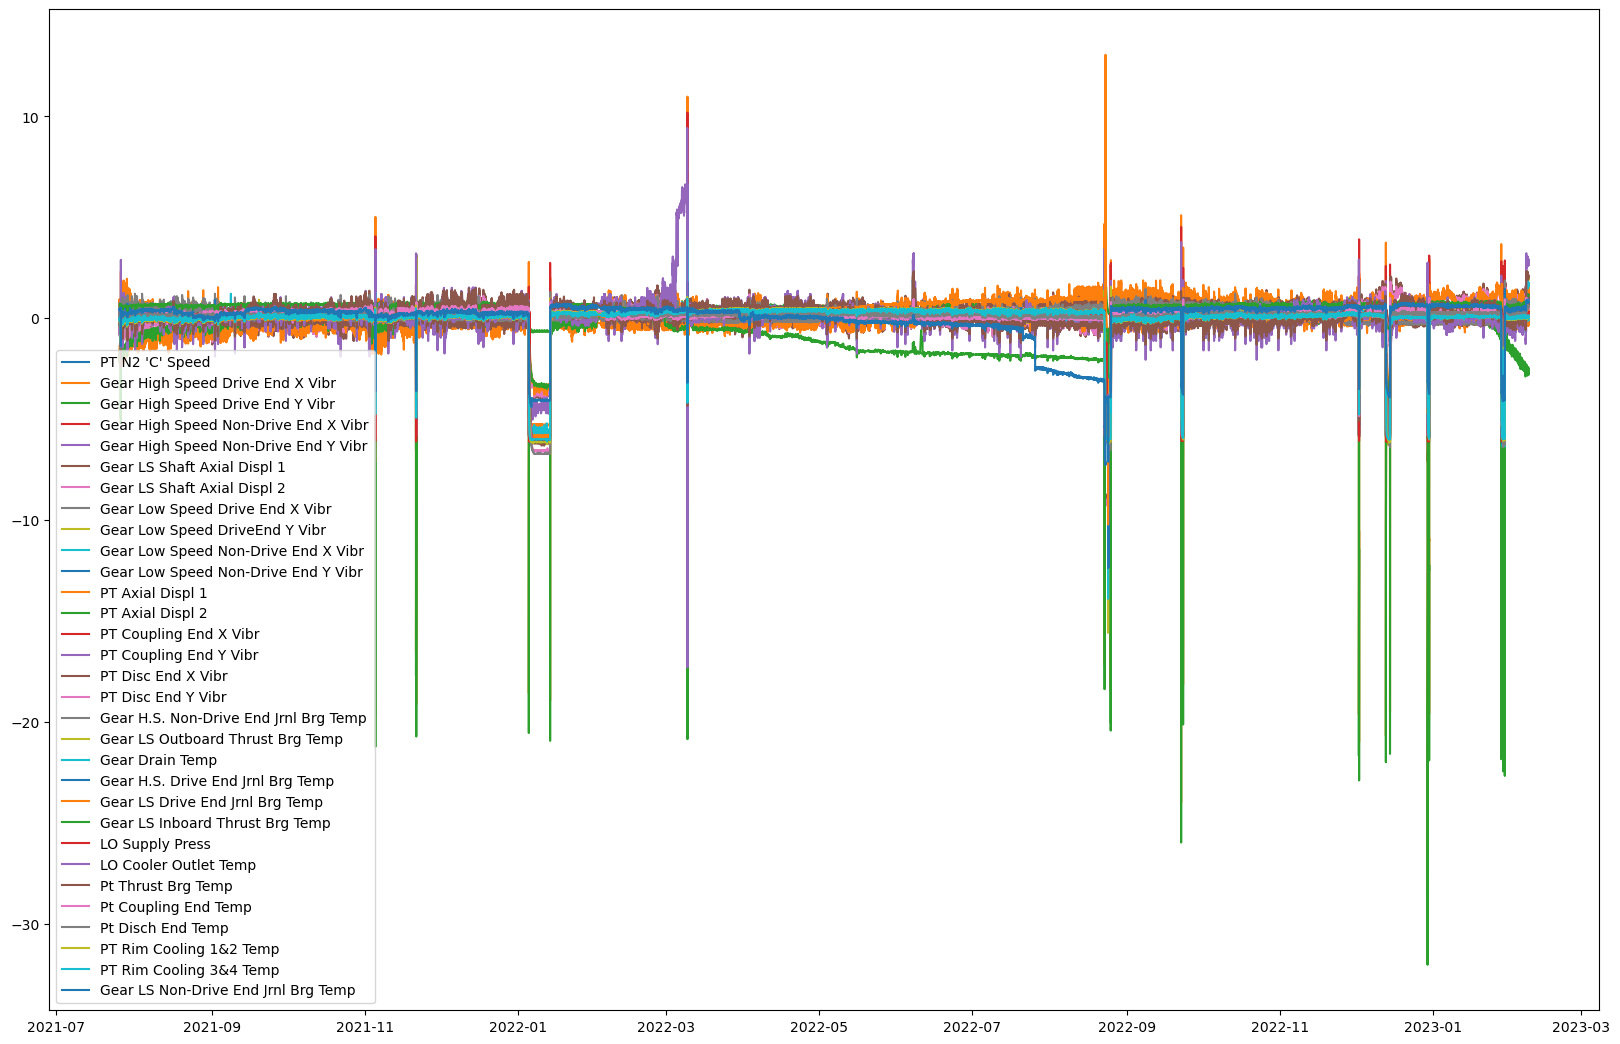

In [10]:
# pd.DataFrame(df_scaled, columns=df.columns).plot(figsize=(20,8))
df.index = pd.to_datetime(df.index, format='mixed')
plt.figure(figsize=(20,13))
plt.plot(df.index, df_scaled, label=df.columns)
plt.legend()
plt.show()

In [11]:
df.shape
# if 'Gear LS Inboard Thrust Brg Temp' in df.columns:
#     df.drop('Gear LS Inboard Thrust Brg Temp', axis=1, inplace=True)

(161788, 31)

In [12]:
df_sample = df.reset_index().loc[:60000-1]
df_sample.to_csv("../../datasets/turbine-gas-gearbox/data_sample.csv", index=False)

In [13]:
df_sample_test = df.reset_index().loc[60000:70000-1]
df_sample_test.to_csv("../../datasets/turbine-gas-gearbox/data_sample_test.csv", index=False)

## ==========================================

In [14]:
df_sample = pd.read_csv("../../datasets/turbine-gas-gearbox/data_sample.csv", index_col="Timestamp")
print(df_sample.shape)

(60000, 31)


In [15]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle

# scaler = MinMaxScaler([0,1])
scaler = pickle.load(open('StandardScaler-gearbox.pkl', 'rb'))
df_sample_scaled = scaler.transform(df_sample)

[]

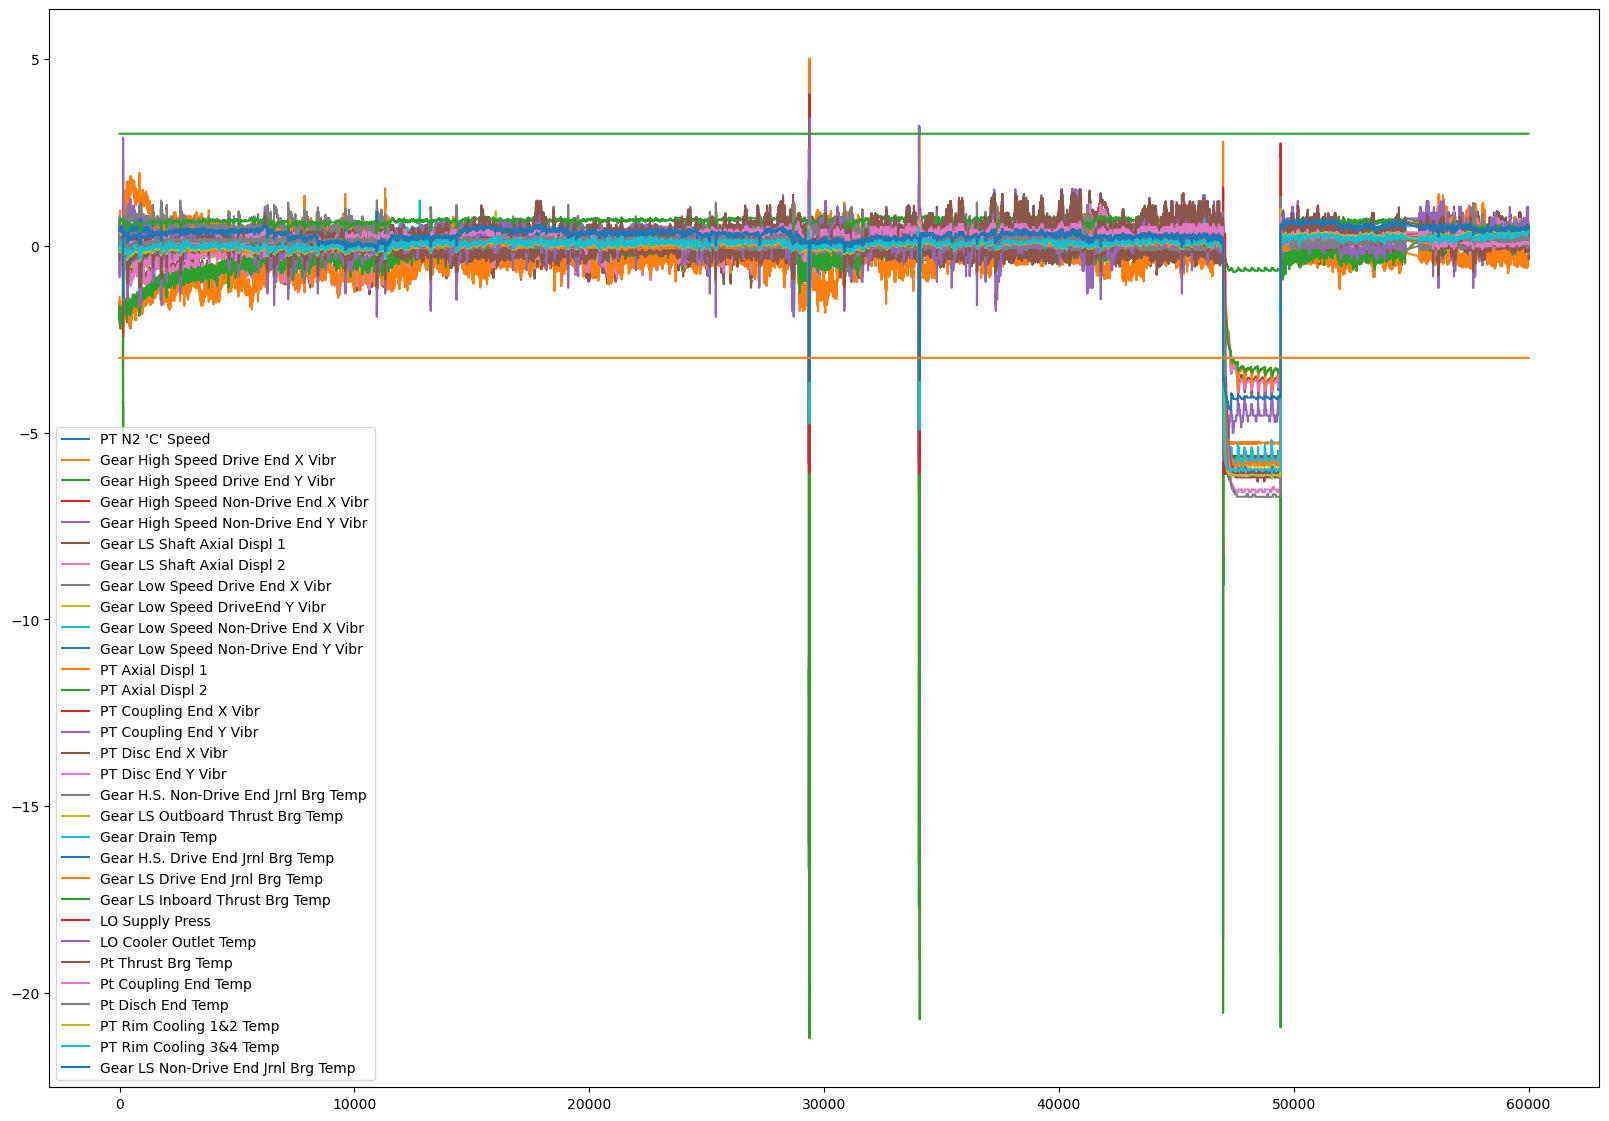

In [16]:
plt.figure(figsize=(20,14))
plt.plot(df_sample_scaled)
plt.plot(np.full(df_sample_scaled.shape[0], -3))
plt.plot(np.full(df_sample_scaled.shape[0], 3))
plt.legend(df_sample.columns)
plt.plot()

In [17]:
df_sample['label'] = np.where(np.any((df_sample_scaled < -3) | (df_sample_scaled > 3), axis=1), 1, 0)

In [18]:
# from sklearn.neighbors import LocalOutlierFactor
# lof = LocalOutlierFactor()

# yyy = lof.fit_predict(df_sample_scaled)

[]

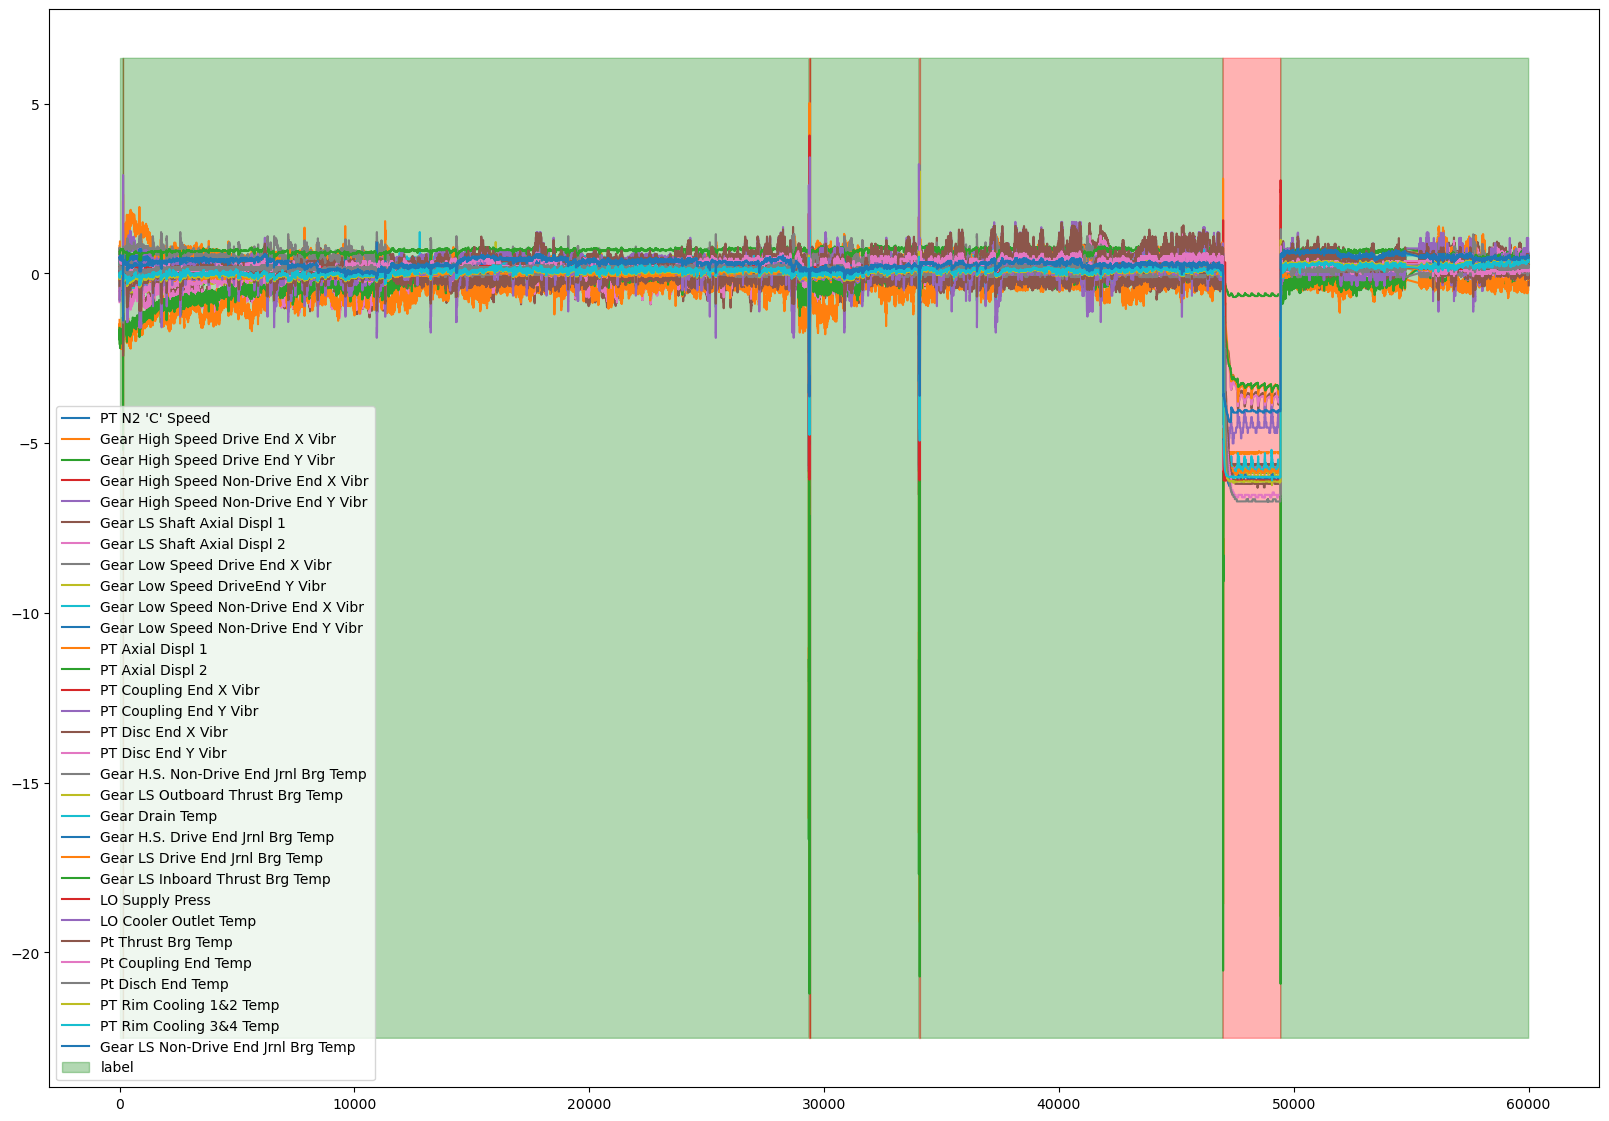

In [19]:
plt.figure(figsize=(20,14))
plt.plot(df_sample_scaled)
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(np.arange(0, df_sample_scaled.shape[0]), ymin, ymax, where=(df_sample['label'] == 0), color='green', alpha=0.3)
plt.fill_between(np.arange(0, df_sample_scaled.shape[0]), ymin, ymax, where=(df_sample['label'] == 1), color='red', alpha=0.3)
plt.legend(df_sample.columns)
plt.plot()

In [20]:
df_sample.loc[df_sample['label'] == 0,:].shape

(57449, 32)

In [21]:
df_sample_scaled = scaler.transform(df_sample.loc[df_sample['label'] == 0,:].drop("label", axis=1))

[]

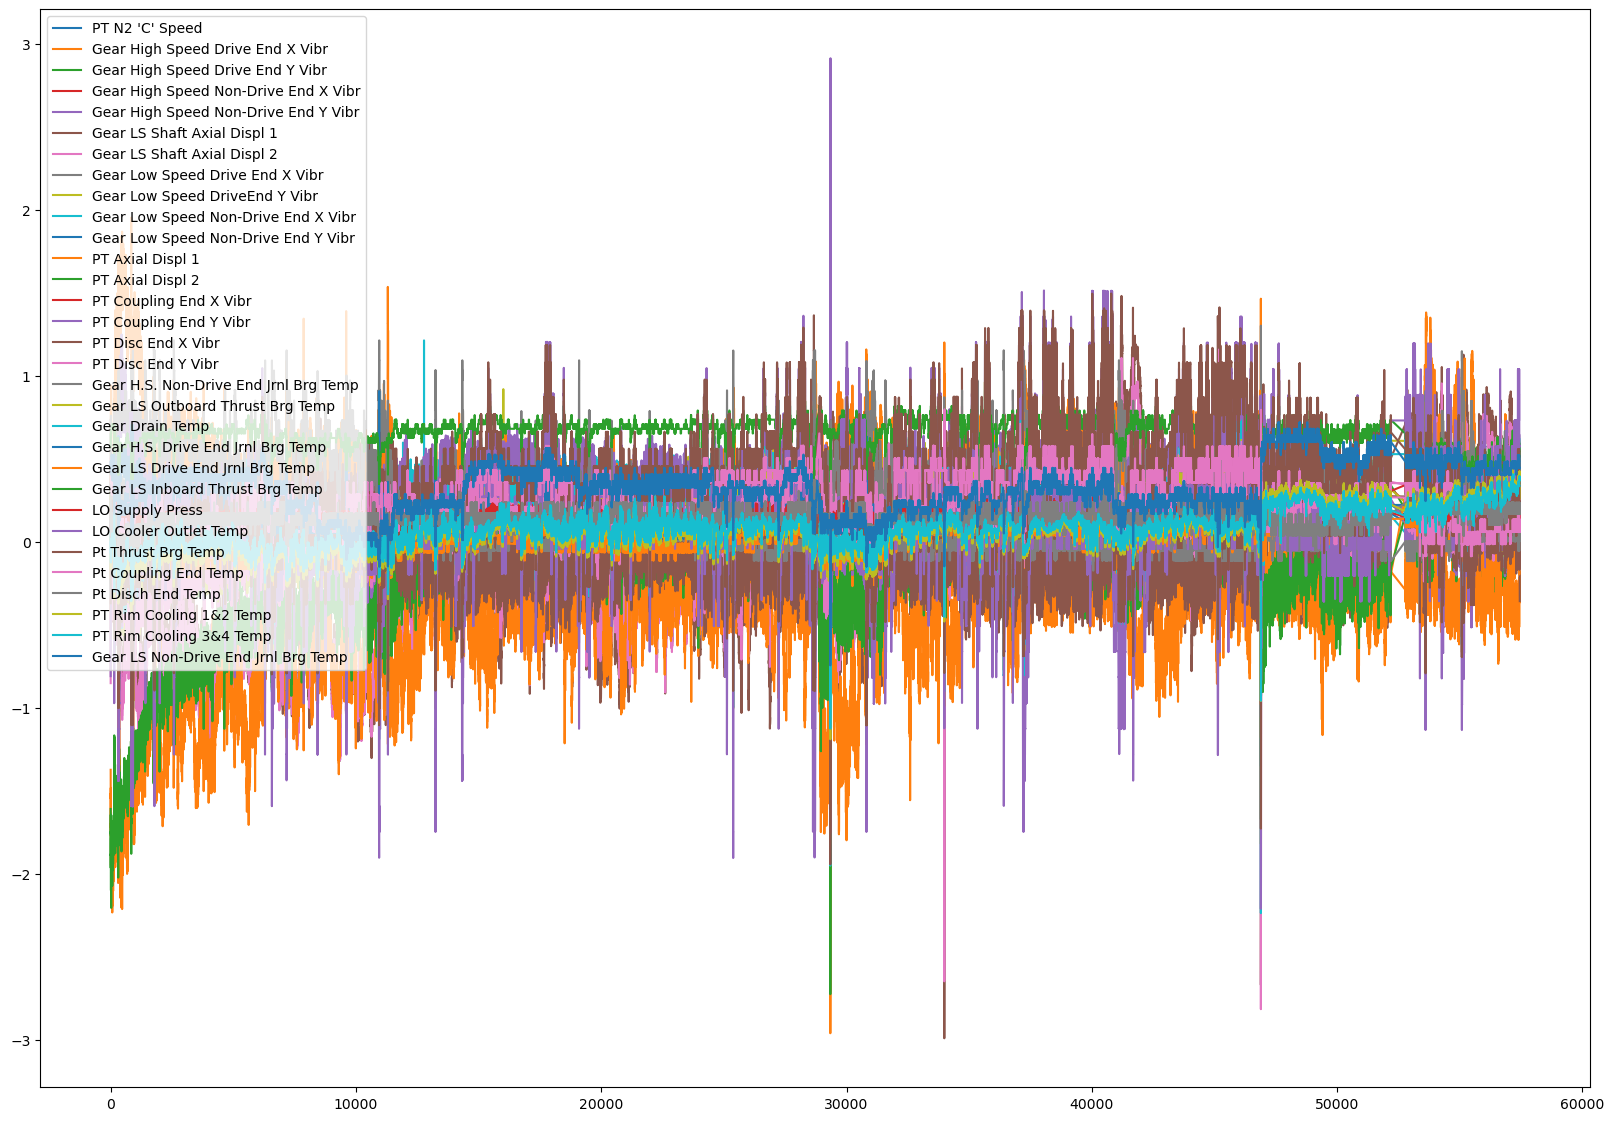

In [22]:
plt.figure(figsize=(20,14))
plt.plot(df_sample_scaled)
plt.legend(df_sample.columns)
plt.plot()

In [23]:
# df_sample_scaled_3d = convert_time_window(df_sample_scaled, 20)
df_sample.columns[:-1]

Index(['PT N2 'C' Speed', 'Gear High Speed Drive End X Vibr',
       'Gear High Speed Drive End Y Vibr',
       'Gear High Speed Non-Drive End X Vibr',
       'Gear High Speed Non-Drive End Y Vibr', 'Gear LS Shaft Axial Displ 1',
       'Gear LS Shaft Axial Displ 2', 'Gear Low Speed Drive End X Vibr',
       'Gear Low Speed DriveEnd Y Vibr', 'Gear Low Speed Non-Drive End X Vibr',
       'Gear Low Speed Non-Drive End Y Vibr', 'PT Axial Displ 1',
       'PT Axial Displ 2', 'PT Coupling End X Vibr', 'PT Coupling End Y Vibr',
       'PT Disc End X Vibr', 'PT Disc End Y Vibr',
       'Gear H.S. Non-Drive End Jrnl Brg Temp',
       'Gear LS Outboard Thrust Brg Temp', 'Gear Drain Temp',
       'Gear H.S. Drive End Jrnl Brg Temp', 'Gear LS Drive End Jrnl Brg Temp',
       'Gear LS Inboard Thrust Brg Temp', 'LO Supply Press',
       'LO Cooler Outlet Temp', 'Pt Thrust Brg Temp', 'Pt Coupling End Temp',
       'Pt Disch End Temp', 'PT Rim Cooling 1&2 Temp',
       'PT Rim Cooling 3&4 Temp', 'Gea

In [24]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Function to train and forecast using ARIMA for a given feature
def train_arima(series_train):
    # Split into train and test (80% train, 20% test)
    
    
    # Fit ARIMA model
    model = ARIMA(series_train, order=(5, 1, 0))  # Adjust (p, d, q) based on the ACF/PACF plot
    model_fit = model.fit()
    return model_fit

def forecast_arima(arima_model, series_forecast):
    
    forecast = arima_model.forecast(steps=len(series_forecast))
    mse = mean_squared_error(series_forecast, forecast)
    return forecast, mse


In [25]:
arima_models = []
# Loop through all features and apply ARIMA
for i, feature in enumerate(df_sample.columns[:-1]):
    print(f'Training ARIMA for {feature}')
    series = df_sample_scaled[:,i]
    arima_models.append(train_arima(series))
    # forecast, mse = train_arima(series)
    # print(f'MSE for {feature}: {mse}')

Training ARIMA for PT N2 'C' Speed
Training ARIMA for Gear High Speed Drive End X Vibr
Training ARIMA for Gear High Speed Drive End Y Vibr
Training ARIMA for Gear High Speed Non-Drive End X Vibr
Training ARIMA for Gear High Speed Non-Drive End Y Vibr
Training ARIMA for Gear LS Shaft Axial Displ 1
Training ARIMA for Gear LS Shaft Axial Displ 2
Training ARIMA for Gear Low Speed Drive End X Vibr


/home/farras/miniconda3/envs/tensor_gpu/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training ARIMA for Gear Low Speed DriveEnd Y Vibr
Training ARIMA for Gear Low Speed Non-Drive End X Vibr


/home/farras/miniconda3/envs/tensor_gpu/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training ARIMA for Gear Low Speed Non-Drive End Y Vibr


/home/farras/miniconda3/envs/tensor_gpu/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training ARIMA for PT Axial Displ 1
Training ARIMA for PT Axial Displ 2
Training ARIMA for PT Coupling End X Vibr
Training ARIMA for PT Coupling End Y Vibr


/home/farras/miniconda3/envs/tensor_gpu/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training ARIMA for PT Disc End X Vibr
Training ARIMA for PT Disc End Y Vibr
Training ARIMA for Gear H.S. Non-Drive End Jrnl Brg Temp


/home/farras/miniconda3/envs/tensor_gpu/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training ARIMA for Gear LS Outboard Thrust Brg Temp
Training ARIMA for Gear Drain Temp
Training ARIMA for Gear H.S. Drive End Jrnl Brg Temp
Training ARIMA for Gear LS Drive End Jrnl Brg Temp
Training ARIMA for Gear LS Inboard Thrust Brg Temp
Training ARIMA for LO Supply Press
Training ARIMA for LO Cooler Outlet Temp


: 

## ============================================

In [33]:
forecast

array([0.24758768, 0.24759614, 0.24759493, ..., 0.24759442, 0.24759442,
       0.24759442])

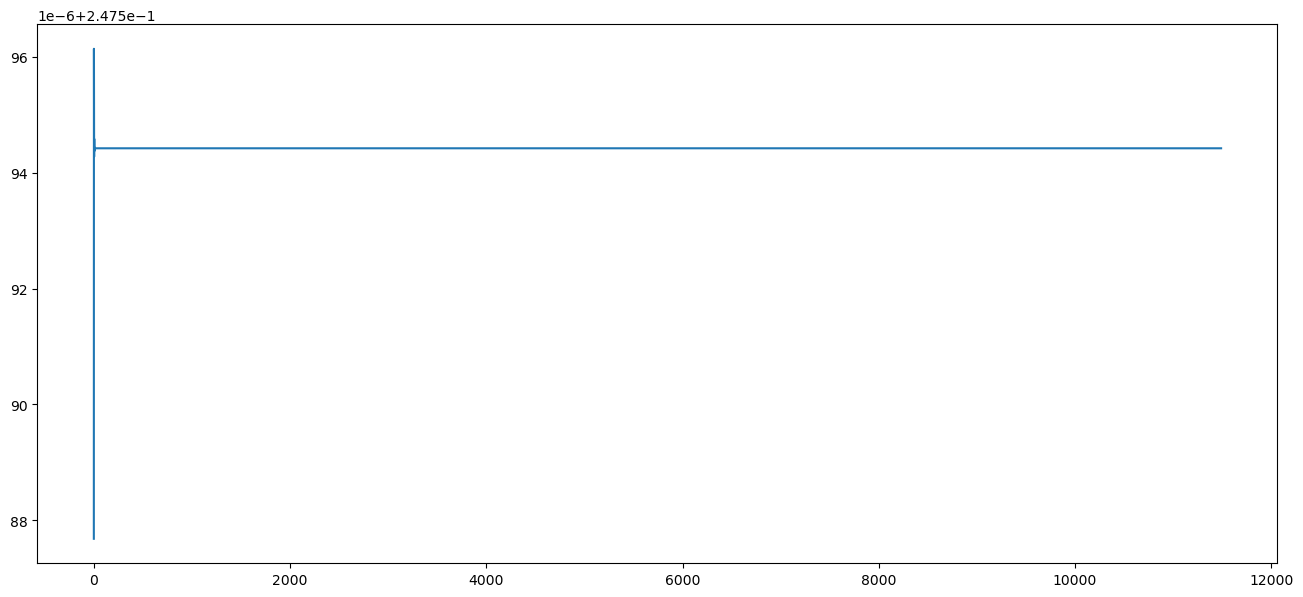

In [32]:
plt.figure(figsize=(16,7))
plt.plot(forecast)
plt.show()

## ===============================================

In [28]:
df_sample_test = pd.read_csv("../../datasets/turbine-gas-gearbox/data_sample_test.csv", index_col="Timestamp")
scaler_test = pickle.load(open('StandardScaler-gearbox.pkl', 'rb'))
df_sample_test_scaled = scaler_test.transform(df_sample_test)

In [29]:
df_sample_test_label = np.where(np.any((df_sample_test_scaled < -3) | (df_sample_test_scaled > 3), axis=1), 1, 0)

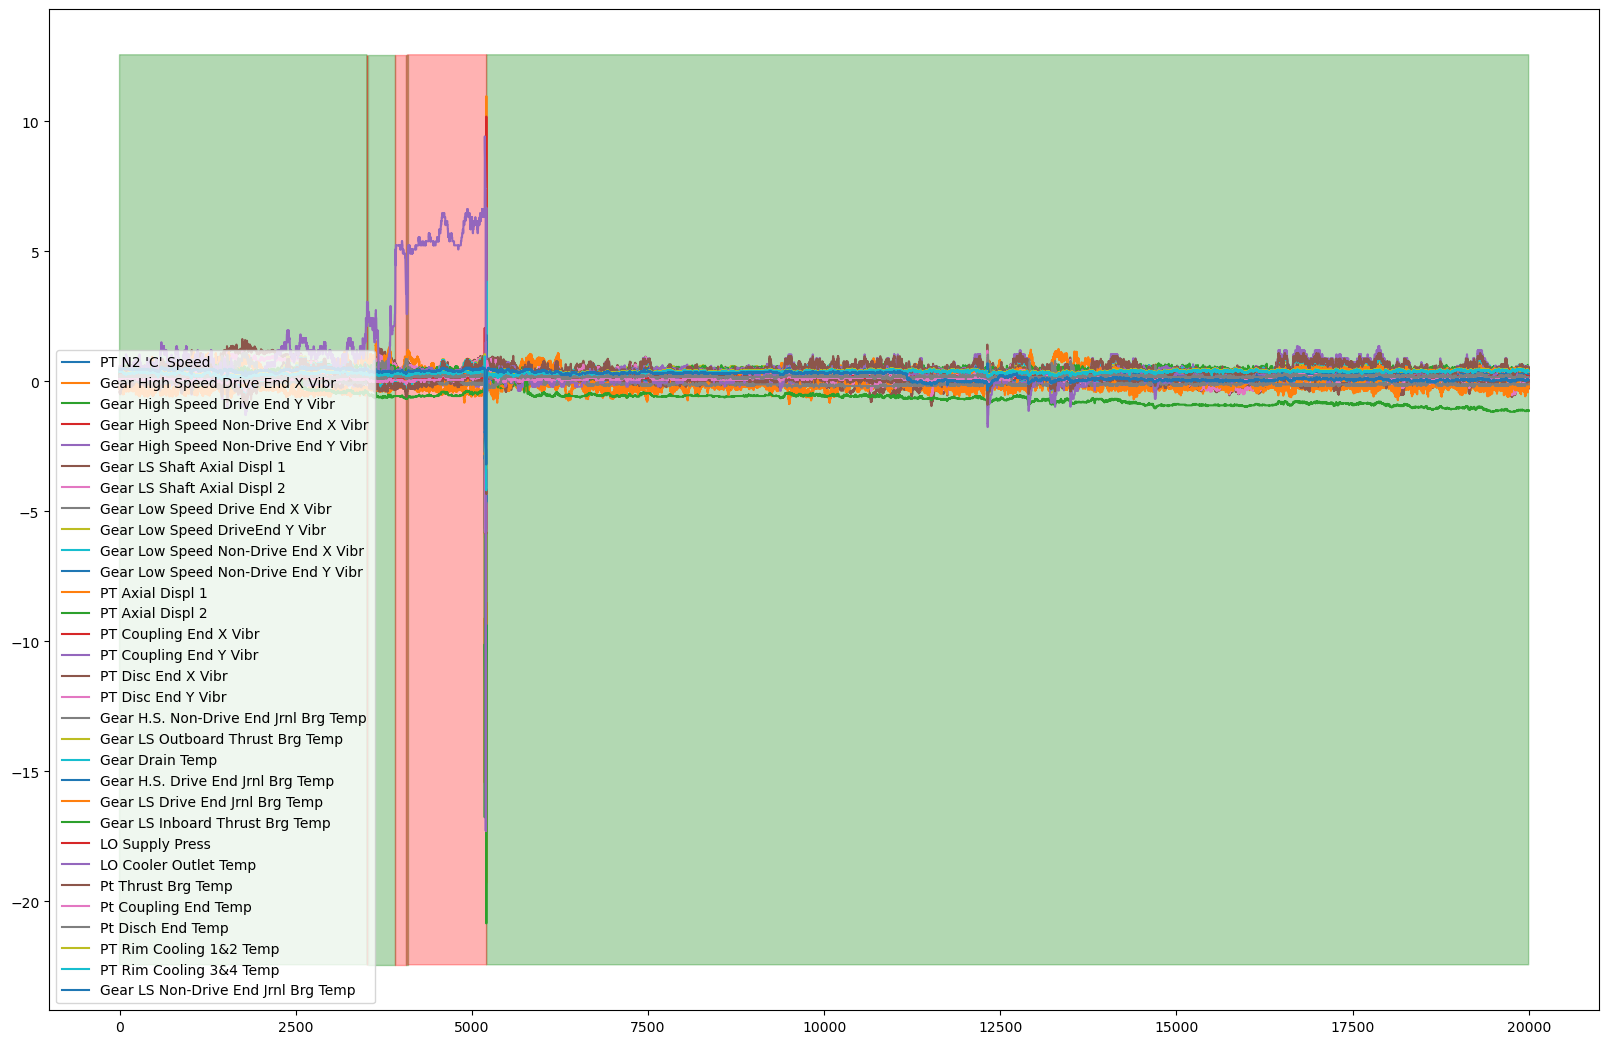

In [10]:
plt.figure(figsize=(20,13))
plt.plot(df_sample_test_scaled)
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(np.arange(0, df_sample_test_scaled.shape[0]), ymin, ymax, where=(df_sample_test_label == 0), color='green', alpha=0.3)
plt.fill_between(np.arange(0, df_sample_test_scaled.shape[0]), ymin, ymax, where=(df_sample_test_label == 1), color='red', alpha=0.3)
plt.legend(df_sample_test.columns)
plt.show()

In [ ]:
residuals = df_sample_test_scaled - forecast
threshold = 3 * np.std(residuals)

# Detect anomalies (where residual exceeds threshold)
anomalies = np.abs(residuals) > threshold

# Plot anomalies
plt.plot(df_sample_test_scaled.index, df_sample_test_scaled, label='Actual')
plt.plot(df_sample_test_scaled.index, forecast, label='Forecast', color='red')
plt.scatter(df_sample_test_scaled.index[anomalies], df_sample_test_scaled[anomalies], color='green', label='Anomalies')
plt.legend()
plt.show()

In [13]:
pred = model.predict(df_sample_test_scaled_3d)

2024-10-15 09:09:02.452479: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


625/625 [==============================] - 8s 11ms/step


In [14]:
pred_2d_inv = inverse_convert_time_window(pred)
# r_e = calculate_reconstruction_loss(df_sample_test_scaled, pred_2d_inv)

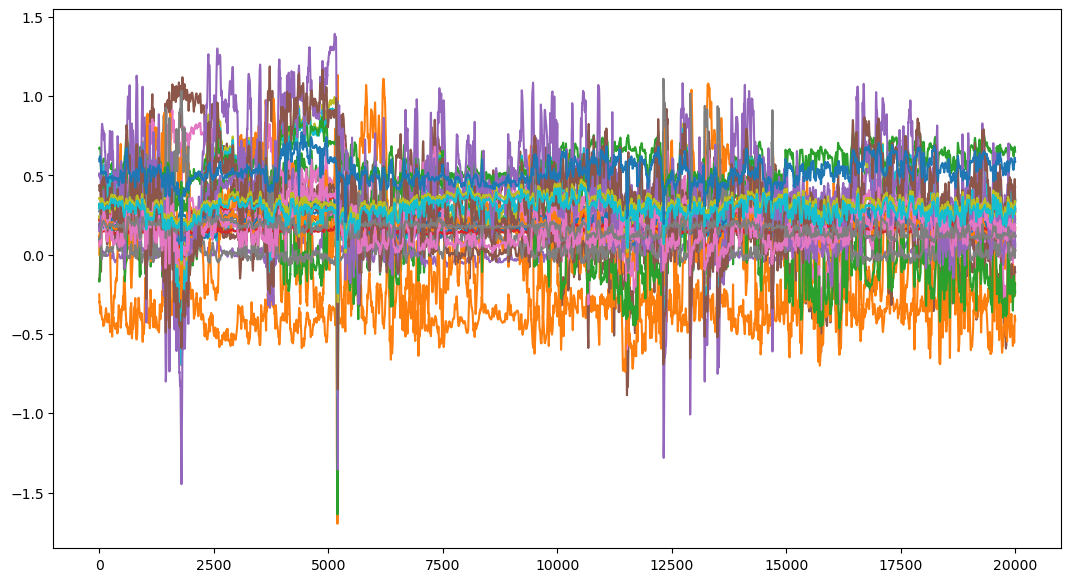

In [15]:
plt.figure(figsize=(13,7))
# plt.plot(df_sample_test_scaled)
plt.plot(pred_2d_inv)
plt.show()

In [16]:
r_e = calculate_reconstruction_loss(df_sample_test_scaled, pred_2d_inv)
# thres = 0.5831722671849883
# thres = 0.03036027381691517
# thres = 0.034154447668272886 + (1.5 * 0.008287947844526241)

In [20]:
thres, f1, y_pred = find_optimal_threshold((r_e), np.array(df_sample_test_label))
print(thres, f1)

0.25446139434202997 0.998259439838238


In [18]:
thres = 0.2544613943420299
y_pred = np.where((r_e > thres) ,1, 0)

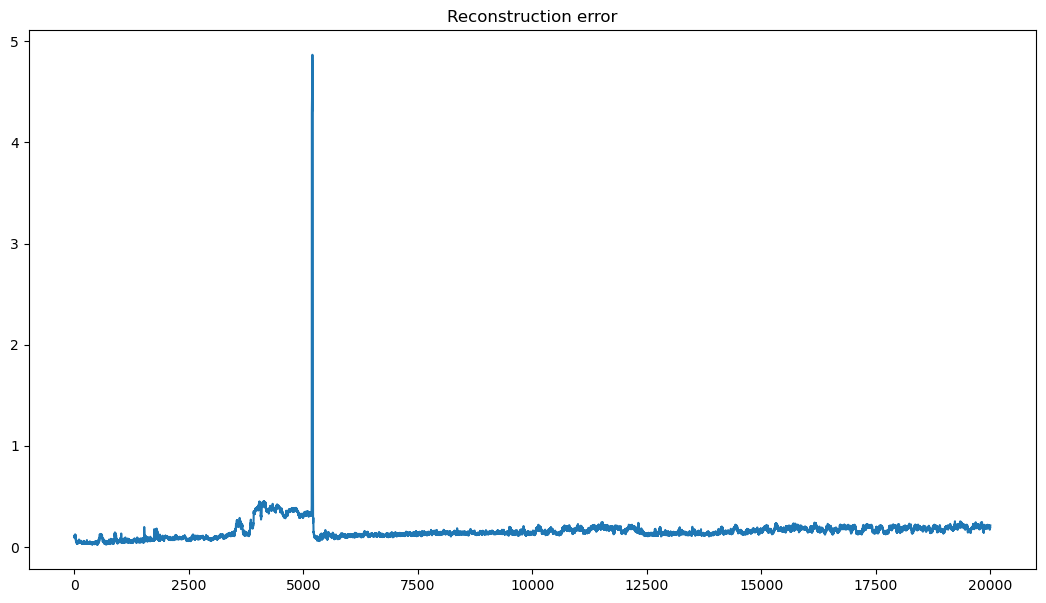

In [18]:
# iqr = np.percentile(r_e, 75) - np.percentile(r_e, 25)

plt.figure(figsize=(13,7))
plt.plot(r_e)
# plt.plot(np.full(r_e.shape[0], thres))
xmin, xmax, ymin, ymax = plt.axis()
# plt.fill_betweenx(np.arange(thres-iqr, thres+iqr), r_e.shape[0], color='gray', alpha=0.3)
plt.title("Reconstruction error")
plt.show()

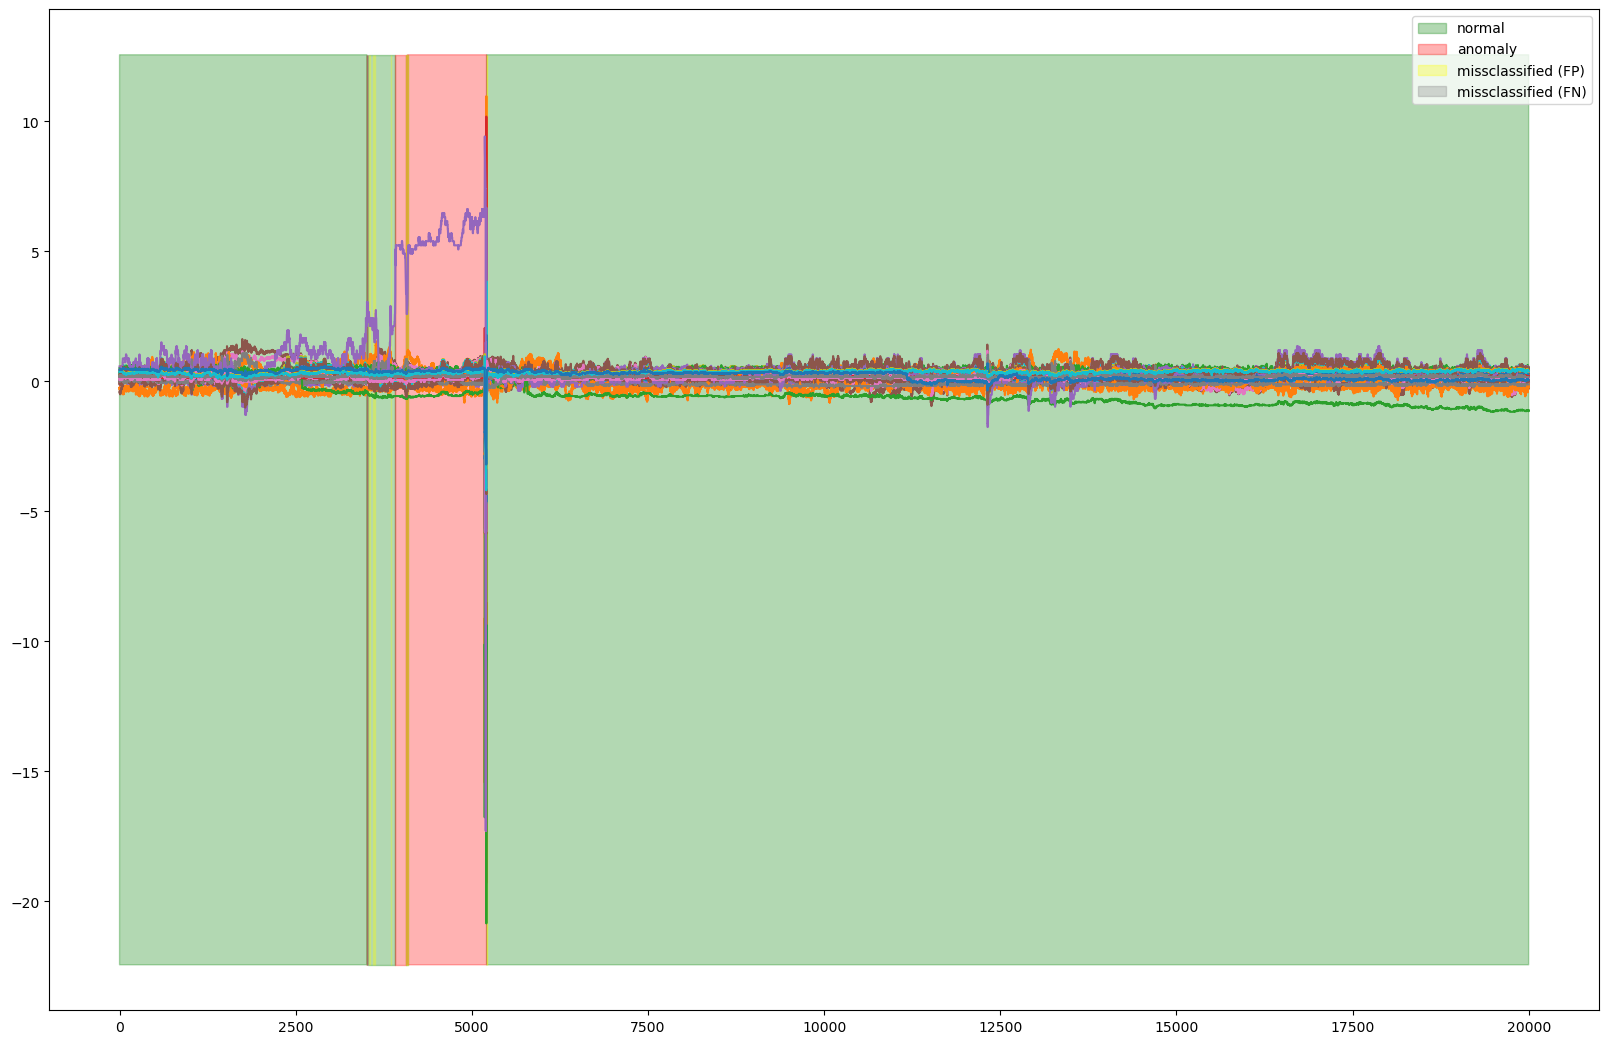

In [23]:
plt.figure(figsize=(20,13))
plt.plot(df_sample_test_scaled)
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(np.arange(0, df_sample_test_scaled.shape[0]), ymin, ymax, where=(df_sample_test_label == 0), color='green', alpha=0.3, label='normal')
plt.fill_between(np.arange(0, df_sample_test_scaled.shape[0]), ymin, ymax, where=(df_sample_test_label == 1), color='red', alpha=0.3, label='anomaly')
plt.fill_between(np.arange(0,df_sample_test_scaled.shape[0]), ymin, ymax,where=(~df_sample_test_label.astype(bool) & y_pred ), color='yellow', alpha=0.3, label='missclassified (FP)')
plt.fill_between(np.arange(0,df_sample_test_scaled.shape[0]), ymin, ymax,where=(df_sample_test_label.astype(bool) & ~y_pred ), color='gray', alpha=0.3, label='missclassified (FN)')
plt.legend()
plt.show()

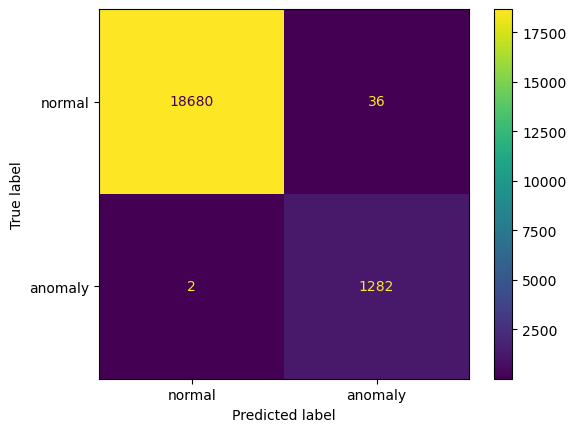

In [25]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(np.array(df_sample_test_label).astype(bool), y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['normal', 'anomaly'])
cm_display.plot()

In [26]:
print("Accuracy: ", metrics.accuracy_score(np.array(df_sample_test_label).astype(bool), y_pred))
print("F1-score: ", metrics.f1_score(np.array(df_sample_test_label).astype(bool), y_pred))

Accuracy:  0.9981
F1-score:  0.9853958493466565
